In [101]:
import numpy as np
import matplotlib.pyplot as plt
from makedataset import get_signal_data, generate_noise,bandpass_filter, VEM_to_eV, pad_and_truncate, SNR


# varry freq and posistion and amplitude
def generate_signals():
    signals = []
    density = 1
    time_start = 0       # Start time in microseconds
    time_end = 3
    num_points = 1000 
    amplitude = 1/4
    frequencys = np.linspace(50,80e6,2000)
    pad_lengths = np.arange(0,900,10)
    time = np.linspace(time_start, time_end, num_points) * 1e-6  # Convert to seconds
    for pad_length in pad_lengths:
        for frequency in frequencys:
            wave_packet = amplitude*np.exp(-((time- 1.5e-6) ** 2) / (2 * (0.5e-6) ** 2)) * np.sin(density * 2 * np.pi * frequency * time)
            out = pad_and_truncate(wave_packet, pad_length)
            if SNR(out) < 3.2 and SNR(out) > 2:
                signals.append(out)
    return signals
                
n_train = 40000
n_test = 10000

signals = generate_signals()

N = len(signals)
p = 0.01
noise_vs_signal_dist = np.random.choice([0, 1], size=N, p=[1-p, p])

for i in range(N):
    if noise_vs_signal_dist[i] == 0:
        noise = generate_noise(1000,3)
        filtered_signal = bandpass_filter(noise, 30, 80, fs=180)
        traces.append(filtered_signal)
    elif noise_vs_signal_dist[i] ==1:
        noise = generate_noise(1000,3)
        filtered_signal = bandpass_filter(noise, 30, 80, fs=180)
        traces.append(filtered_signal+signals[i])

In [102]:
x_train_array = np.array(x_train)
y_train_array = np.array(y_train)
x_test_array= np.array(x_test)
y_test_array = np.array(y_test)


y_train_array = (y_train_array.std(axis=-1) != 0).astype(float)
y_test_array = (y_test_array.std(axis=-1) != 0).astype(float)


signals_shape = np.array(signals)

print(x_train_array.shape)
print(y_train_array.shape)


print(x_test_array.shape)
print(y_test_array.shape)

print(signals_shape.shape)

(40000, 1000)
(40000,)
(10000, 1000)
(10000,)
(92356, 1000)


In [103]:
sigma = x_train_array.std()
x_train_array /= sigma
x_test_array /= sigma

In [104]:
#Script for training model

import tensorflow as tf


from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Activation #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow import keras

input_length = 1000
num_channels = 1

#Calling He_Normal Initializer
intializer = tf.keras.initializers.HeNormal(seed = 42)


model = Sequential()

# First block of Conv1D layers
model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='valid', 
                 kernel_initializer=intializer, input_shape=(input_length, num_channels), 
                 activation='relu',
                   name='Block_1_1D_Conv_Layer_1'))
model.add(BatchNormalization(name='Batch_Norm_Block_1_Layer_1'))


model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='valid', 
                 kernel_initializer=intializer, activation='relu',
                   name='Block_1_1D_Conv_Layer_2'))
model.add(BatchNormalization(name='Batch_Norm_Block_1_Layer_2'))


# Max pooling after the first block
model.add(MaxPooling1D(pool_size=5, name="Max_Pooling"))

# Second block of Conv1D layers
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='valid', 
                 kernel_initializer=intializer, activation='relu',
                   name='Block_2_1D_Conv_Layer_1'))
model.add(BatchNormalization(name='Batch_Norm_Block_2_Layer_1'))


model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='valid', 
                 kernel_initializer=intializer, activation='relu',
                   name='Block_2_1D_Conv_Layer_2'))
model.add(BatchNormalization(name='Batch_Norm_Block_2_Layer_2'))


# Flatten the output from the convolutional layers
model.add(Flatten(name='Flatten'))

# Fully connected layers
model.add(Dense(units=64, kernel_initializer=intializer, activation='relu', 
                name='Dense_64'))


model.add(Dense(units=8, kernel_initializer=intializer, activation='relu', 
                name='Dense_8'))

# Output layer
model.add(Dense(units=1, kernel_initializer=intializer, activation="sigmoid", 
                name='Dense_2'))



# Compile the model
#Implementing the learning rate schedule makes the model crash so I took it out for now.
# lr_schedule = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.8, staircase=True)

model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
summary = model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Block_1_1D_Conv_Layer_1 (C  (None, 996, 256)          1536      
 onv1D)                                                          
                                                                 
 Batch_Norm_Block_1_Layer_1  (None, 996, 256)          1024      
  (BatchNormalization)                                           
                                                                 
 Block_1_1D_Conv_Layer_2 (C  (None, 992, 256)          327936    
 onv1D)                                                          
                                                                 
 Batch_Norm_Block_1_Layer_2  (None, 992, 256)          1024      
  (BatchNormalization)                                           
                                                                 
 Max_Pooling (MaxPooling1D)  (None, 198, 256)        

In [105]:
results = model.fit(x_train_array[..., np.newaxis], 
                    y_train_array, 
                    batch_size=500, 
                    epochs=1, 
                    verbose=1, 
                    validation_split=0.1)

72/72 [==============================] - 24s 277ms/step - loss: 0.0353 - accuracy: 0.9836 - val_loss: 30.2240 - val_accuracy: 0.0335


In [106]:
y_pred = model.predict(x_test_array[..., np.newaxis], verbose=1)

313/313 [==============================] - 2s 6ms/step


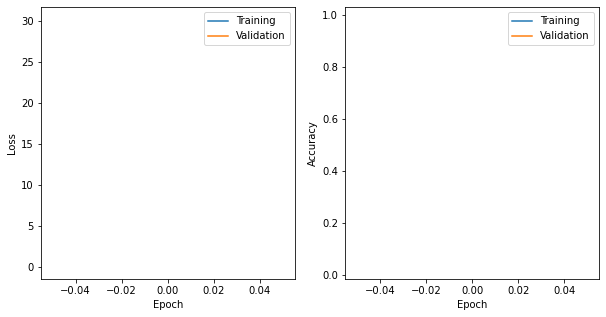

In [107]:
from plotting import plot_model_history

plot_model_history(results)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.0342

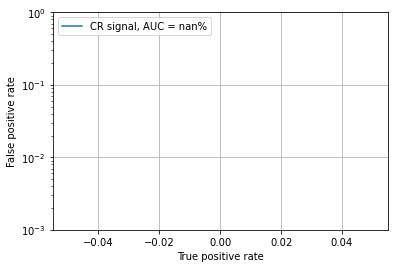

In [109]:
from plotting import make_roc
from sklearn.metrics import accuracy_score

make_roc(y_test_array, y_pred, ["CR signal"])
accuracy_score(y_test_array, y_pred > 0.5)